<a href="https://colab.research.google.com/github/rchandran7/GoldfishLifespanPrediction/blob/main/GoldFishLifespanPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Question
We were curious if there was a way to accurately predict the lifespan of animal based on their living environment. To investigate this, we decided to explore a dataset on the lifespans of goldfish. Can we effectively predict the lifespan of a goldfish given environmental and biological data?

## Our Approach
Given the nature of the goldfish lifespan prediction task, we'll use regression algorithms and a neural network. In our approach, we considered linear regression with L1 regularization (LASSO), Bayesian regression with L2 regularization and PCA (Principle Component Analysis), and a simple neural network.

## Results Prediction
Given the nature of the goldfish lifespan prediction task, we hypothesize that the relationship between factors such as gender and habitat with the goldfish lifespan will be relatively linear. Therefore, we expect a linear regression to be a suitable and effective algorithm for this prediction. The simplicity of linear regression along with regularization should not overfit our relatively small data. Along with some feature implementations and regularizations, we anticipate the linear models (Bayesian and LASSO) to perform well.

## Motivation
While predicting the lifespan of goldfish might seem specific, the underlying concept of using machine learning for predictive modeling can be applied to various domains. For instance, understanding the factors influencing a goldfish's lifespan can be analogous to predicting the lifespan or health outcomes in other living organisms or systems. This approach can be valuable in a broader context, such as predicting health outcomes for different species or optimizing conditions in controlled environments.

## Data Preprocessing
The goldfish data set, we utilized required some preprocessing before fitting our model. First, we load in our necessary libraries. 

In [6]:
import sys  # For command line file input.
import pandas as pd  # For easy date frame manipulation
from sklearn.model_selection import train_test_split  # To split processed data

Then, we create a helper function to create a dummy variable column. Dummy variable columns are used to represent categorical data numerically (0 or 1).

In [2]:
def dummy_variable_col(df, col):
    # Create dummy variables for the specified column
    df_temp = pd.get_dummies(df[col])
    df_temp = df_temp.astype(int)
    # Concatenate the dummy variables to the original DataFrame and reindex
    df = pd.concat([df, df_temp], axis=1,).reindex(df.index)
    # Drop the original column as dummy variables are created
    df.drop(col, axis=1, inplace=True)
    return df

Next, we read in the csv file from the command-line and perform some preprocessing that will be beneficial when creating our models. We opted to drop the id and color features as we believe they are not statistically significant. Then we create dummy variable columns for each category in habitat, so all our data is numerical. (Code will error as no command line input can be passed in.)

In [7]:
# Check if the correct number of command-line arguments is provided
if len(sys.argv) == 3:
    # Assign input and output file names from command-line arguments
    file_input = sys.argv[1]
    file_output = sys.argv[2]
else:
    # Print an error message if the number of arguments is invalid
    print("Error: Invalid number of arguments.", file=sys.stderr)

# Read the input CSV file into a Pandas DataFrame
df = pd.read_csv(file_input)
df = df.drop(['id', 'color'], axis=1)
df = df.dropna() # Drop any null (empty) values
df = dummy_variable_col(df, 'habitat')
df['Gender'] = df['Gender'].replace({True: 'male', False: 'female'})

Lastly, we split the processed data frame into training and testing splits. We opted for 90/10 split to ensure we had enough training data. Output the train and data sets as CSV files.

In [8]:
# Split the DataFrame into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Write the training and testing sets to CSV files
train_df.to_csv(file_output + '_train.csv', index=False)
test_df.to_csv(file_output + '_test.csv', index=False)

## LASSO

To begin LASSO regression, import the necessary libraries. 

In [18]:
from sklearn.linear_model import Lasso  # Lasso regression model
# Metric for evaluating model performance
from sklearn.metrics import mean_squared_error
# Data preprocessing tools
from sklearn.preprocessing import StandardScaler, LabelEncoder
# Hyperparameter tuning using grid search
from sklearn.model_selection import GridSearchCV
import pandas as pd  # Data manipulation
import matplotlib.pyplot as plt  # Data visualization

This next code section reads processed new fish data from the CSV files. It encodes the 'Gender' column numerically using LabelEncoder and performs feature scaling on the input features using StandardScaler for uniformity in scale during training. We also specify that 'life_span' is our target variable to predict.

In [19]:
# Read training and testing datasets
df_train = pd.read_csv('new_fish_train.csv')
df_test = pd.read_csv('new_fish_test.csv')

# Encode 'Gender' column using LabelEncoder
le = LabelEncoder()
df_train['Gender'] = le.fit_transform(df_train['Gender'])

# Preprocess 'Gender' column for testing set
df_test['Gender'] = le.transform(df_test['Gender'])

# Prepare feature and target variables for training and testing
X_train = df_train.drop(['life_span'], axis=1)
X_test = df_test.drop(['life_span'], axis=1)
y_train = df_train['life_span']
y_test = df_test['life_span']

# Feature scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Now, we initialize a Lasso regression model to predict outcomes based on our input data. To enhance the model's effectiveness, we employ a technique called hyperparameter tuning, specifically using a process known as Grid Search with cross-validation. This involves systematically exploring different settings for a key configuration parameter (alpha) to discover the values that result in the best model performance. Once identified, these optimal settings are used to fine-tune the Lasso regression model. Subsequently, we leverage this refined model to generate predictions for the test dataset, providing insights into how well the model generalizes to new, unseen data.

In [20]:
# Initialize Lasso regression model
lasso = Lasso()
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0],
}
# Define hyperparameter grid for GridSearchCV
grid_search = GridSearchCV(
    lasso, param_grid, scoring='neg_mean_squared_error', cv=5)
# Perform Grid Search with cross-validation for hyperparameter tuning
grid_search.fit(X_train_scaled, y_train)
# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
# Retrieve the best model from the grid search
best_model = grid_search.best_estimator_
# Make predictions on the test set using the best model
predictions = best_model.predict(X_test_scaled)

Next, we calculate the Mean Squared Error (MSE) as a performance metric, providing a numerical measure of how well our predictions align with the real-life observations.

In [21]:
# Create a DataFrame to compare actual and predicted values
results = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
print(results)

# Calculate Mean Squared Error (MSE) as a performance metric
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 53.68379994063018


Finally, we will create a scatter plot to visualize our predictions and results.

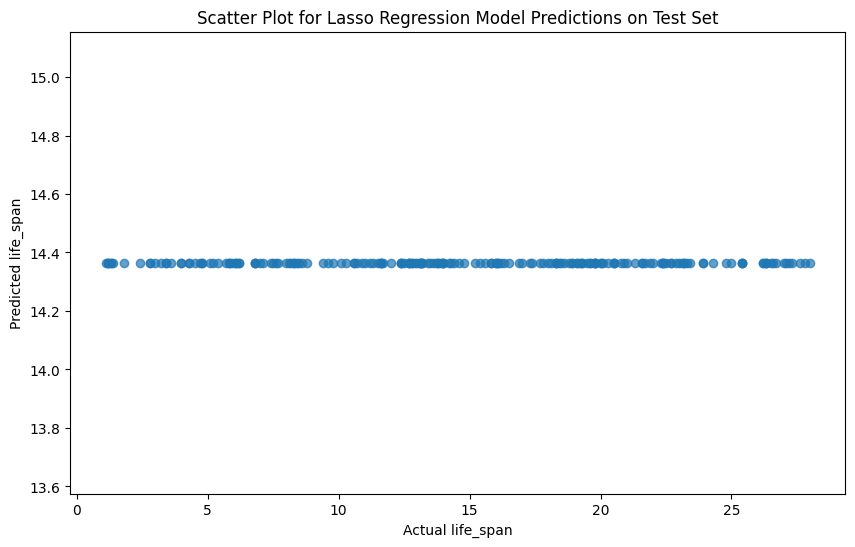

In [22]:
# Visualize the predictions using a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.7)
plt.xlabel('Actual life_span')
plt.ylabel('Predicted life_span')
plt.title('Scatter Plot for Lasso Regression Model Predictions on Test Set')
plt.show()

It is clear to see that LASSO regression did not perform well at all. This model seems to overfit the training data and makes predictions of only around 14 years. We will now explore other models to view their effectiveness in comparison.

## Bayesian Ridge with PCA

To begin we need to import the necessary libraries

In [2]:
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

This next code section reads processed new fish data from the CSV files. It encodes the 'Gender' column numerically using LabelEncoder and performs feature scaling on the input features using StandardScaler for uniformity in scale during training. We also specify that 'life_span' is our target variable to predict.

In [4]:
# Read training and testing sets
df_train = pd.read_csv('new_fish_train.csv')
df_test = pd.read_csv('new_fish_test.csv')

# Preprocess 'Gender' column
le = LabelEncoder()
df_train['Gender'] = le.fit_transform(df_train['Gender'])
df_test['Gender'] = le.transform(df_test['Gender'])

# Split the data into features and target variable
X_train = df_train[['average_length(inches))', 'average_weight(inches))', 'ph_of_water',
                    'Gender', 'idlewater', 'lakes', 'ponds', 'rivers', 'slowmovingwaters']]
X_test = df_test[['average_length(inches))', 'average_weight(inches))', 'ph_of_water',
                  'Gender', 'idlewater', 'lakes', 'ponds', 'rivers', 'slowmovingwaters']]
y_train = df_train['life_span']
y_test = df_test['life_span']

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Now we transform our data using pca in order to reduce the dimensionality and maintain essential variability. This should result in a more efficient analysis.

In [5]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

This code initializes a Bayesian Ridge Regression model and conducts a grid search with cross-validation to find the optimal hyperparameters from a predefined parameter grid. The best model is then used to make predictions on scaled test data, facilitating the selection of hyperparameters that minimize mean squared error and enhance the model's predictive performance.

In [6]:
# Initialize the Bayesian Ridge Regression model
bayesian_ridge = BayesianRidge()

# Define the parameter grid to search
param_grid = {
    'alpha_1': [1e-6, 1e-5, 1e-4, 1e-3],
    'alpha_2': [1e-6, 1e-5, 1e-4, 1e-3],
    'lambda_1': [1e-6, 1e-5, 1e-4, 1e-3],
    'lambda_2': [1e-6, 1e-5, 1e-4, 1e-3],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(bayesian_ridge, param_grid,
                           scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_scaled)

Best Hyperparameters: {'alpha_1': 1e-06, 'alpha_2': 0.001, 'lambda_1': 0.001, 'lambda_2': 0.001}


Now we can print the values along with the mean squared error

In [7]:
# Print actual vs predicted values
results = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
print(results)

mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

     Actual  Predicted
0      23.9  14.331662
1       4.7  14.269553
2      14.0  14.347083
3      27.6  14.503754
4       5.7  14.276544
..      ...        ...
193    23.2  14.365856
194    26.3  14.323041
195    18.3  14.394804
196     5.2  14.455679
197    18.4  14.445678

[198 rows x 2 columns]
Mean Squared Error: 53.54780693173404


Finally we can plot our results

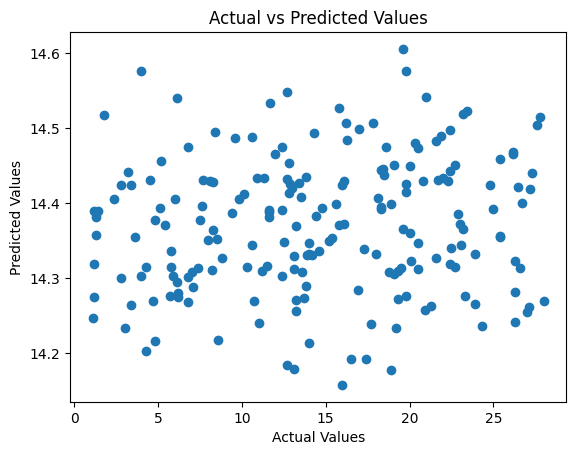

In [8]:

plt.scatter(y_test, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

As you can see, the bayesian ridge regression didn't really work too well. All the values were being predicted to somewhere in the 14's. This could mean that it is overfit or that the data is just not correlated.

Our final attempt was to use a neural network just in case there actually was a correlation that the linear regression models didn't see.

## Neural Network

First, we need to import everything necessary for this model.

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore

2023-12-08 17:30:41.159888: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


This next code section reads processed new fish data from the CSV files. It encodes the 'Gender' column numerically using LabelEncode. We also specify that 'life_span' is our target variable to predict.

In [10]:
# Load your data
df_train = pd.read_csv('new_fish_train.csv')
df_test = pd.read_csv('new_fish_test.csv')

# Label encoding for 'Gender'
le = LabelEncoder()
df_train['Gender'] = le.fit_transform(df_train['Gender'])
df_test['Gender'] = le.transform(df_test['Gender'])

# Extract features and target variable
X_train = df_train.drop(['life_span'], axis=1)
X_test = df_test.drop(['life_span'], axis=1)
y_train = df_train['life_span']
y_test = df_test['life_span']

Now we can define our neural network. We made it three layers, with the first being 16 neurons, second being 8, and the last being 1. The first is 16 neurons because we didn't want to make it too large since our data set is small. For the second layer, we decided to just make it half of the first. The last layer needs to be 1 because it should only output 1 value.

In [11]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=20, validation_split=0.2, verbose=0)

# Evaluate the model on the test set
predictions = model.predict(X_test).flatten()

7/7 [==============================] - 0s 1ms/step


We then print our results along with our mean squared error.

In [12]:
results = pd.DataFrame({'Actual': df_test['life_span'], 'Expected': predictions})
print(results)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

     Actual   Expected
0      23.9  13.210051
1       4.7  13.908318
2      14.0  14.514303
3      27.6  13.506089
4       5.7  14.537471
..      ...        ...
193    23.2  14.643409
194    26.3  14.317965
195    18.3  15.676792
196     5.2  16.195520
197    18.4  14.036224

[198 rows x 2 columns]
Mean Squared Error: 54.610896894957726


Finally, we plot our results.

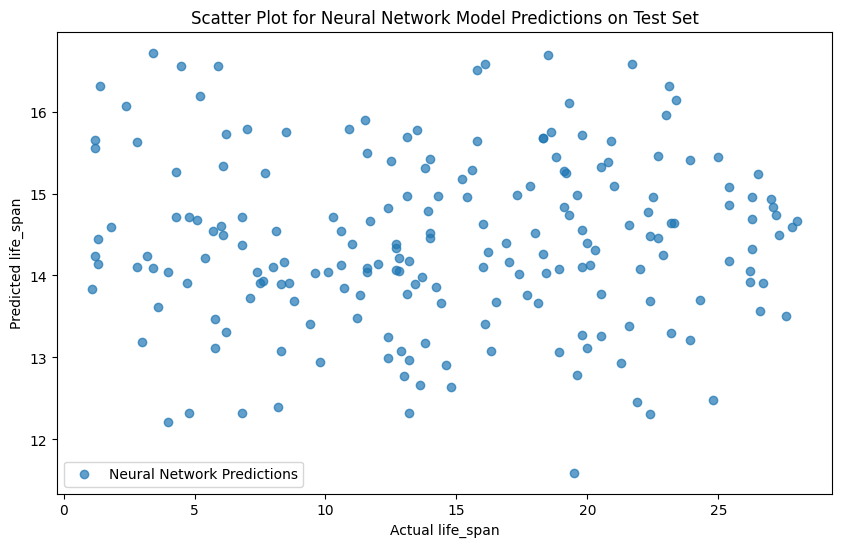

In [13]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, label='Neural Network Predictions', alpha=0.7)
plt.xlabel('Actual life_span')
plt.ylabel('Predicted life_span')
plt.title('Scatter Plot for Neural Network Model Predictions on Test Set')
plt.legend()
plt.show()

The neural network had a lot more variation in its predictions compared to the linear regression models but still wasn't that accurate. This is probably because our data set is either too small or just has no correlation between the features and lifespan.

# Results

### LASSO
MSE = 53.68379994063018
### Bayesian Ridge with PCA
MSE = 53.54780693173404
### Neural Network
MSE = 54.610896894957726

## Conclusion

In our pursuit to predict the lifespan of comet goldfish, we explored various modeling approaches, including LASSO regression, Bayesian Ridge regression coupled with PCA, and a basic neural network. Unfortunately, none of these models worked too well. One reasonable explanation is the absence of significant correlations between the features and the goldfish lifespan within the dataset. Another contributing factor could be the relatively limited size of our dataset, potentially hindering the models from capturing intricate patterns. These challenges underscore the paramount importance of high-quality, relevant data in the success of machine learning endeavors, emphasizing the need for thoughtful feature selection and dataset expansion to improve predictive accuracy in future analyses.

### TLDR
Bad Data = Bad Machine Learning